In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import glob
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import random

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
USER_PATHS = {
    "MAYURESH": {
        "data_path": "/content/drive/MyDrive/CS229 Project FNO/final_generation/simulation_results_final/",
         "output_path": "/content/drive/MyDrive/CS229 Project FNO/tensors new/",
    },
    "SHAUNAK": {
        "data_path": "/content/drive/MyDrive/CS229 Project FNO/final_generation/simulation_results_final/",
        "output_path": "/content/drive/MyDrive/CS229 Project FNO/tensors new/",
    }
    }

In [ ]:
user = "SHAUNAK"
data_path = USER_PATHS[user]["data_path"]
output_path = USER_PATHS[user]["output_path"]

In [ ]:
static_files = sorted(glob.glob(data_path + "static_data_sim*.csv"))
time_series_files = sorted(glob.glob(data_path + "time_series_data_sim*.csv"))

print(len(static_files))
print(len(time_series_files))

assert(len(static_files) == len(time_series_files))
os.makedirs(output_path, exist_ok=True)

len(static_files)

1000
1000


1000

In [ ]:
num_points = 21  # Grid resolution
num_steps = 200  # Time steps
T_context = 3  # Number of past frames used as input
input_channels = 9  # x, y, IC, Dirichlet mask, Neumann mask, BC values, last 3 frames

scaler = MinMaxScaler()

In [ ]:
for i, (static_file, time_series_file) in enumerate(
    tqdm(zip(static_files, time_series_files), total=len(static_files), desc="Generating Tensors", dynamic_ncols=True)
):
    static_df = pd.read_csv(static_file)
    time_series_df = pd.read_csv(time_series_file)

    ic = static_df["Initial_Condition"].values.reshape(num_points, num_points)
    dirichlet_mask = static_df["Dirichlet_Mask"].values.reshape(num_points, num_points)
    neumann_mask = static_df["Neumann_Mask"].values.reshape(num_points, num_points)
    bc_values = static_df["BC_Value"].values.reshape(num_points, num_points)

    u_solution = time_series_df["u(x,y,t)"].values.reshape(num_steps, num_points, num_points)
    # u_solution = u_solution[:, :-1, :-1]  # Reshape into 20x20 (not needed anymore)

    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, num_points), np.linspace(0, 1, num_points))

    local_X, local_Y = [], []
    for t in range(T_context, num_steps - 1):
        input_tensor = np.stack([
            x_grid, y_grid, ic,
            dirichlet_mask, neumann_mask, bc_values,
            u_solution[t - 2], u_solution[t - 1], u_solution[t]
        ], axis=0)  # Shape: (9, 20, 20)

        output_tensor = u_solution[t + 1]  # Shape: (20, 20)
        local_X.append(input_tensor)
        local_Y.append(output_tensor)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(np.array(local_X), dtype=torch.float32)  # (steps, 9, 20, 20)
    Y_tensor = torch.tensor(np.array(local_Y), dtype=torch.float32)  # (steps, 20, 20)

    # ================= SAVE TO .PT =================
    torch.save(X_tensor, os.path.join(output_path, f"X_sim{i}.pt"))
    torch.save(Y_tensor, os.path.join(output_path, f"Y_sim{i}.pt"))

print("✅ All simulations saved as .pt files!")

Generating Tensors: 100%|██████████| 1000/1000 [02:50<00:00,  5.86it/s]

✅ All simulations saved as .pt files!


In [ ]:
train_path = output_path

x_files = sorted(glob.glob(train_path + "X_sim*.pt"))
y_files = sorted(glob.glob(train_path + "Y_sim*.pt"))

# Ensure both lists are of the same length
assert len(x_files) == len(y_files), "Mismatch in number of X and Y files!"

# Zip, shuffle, and unzip
file_pairs = list(zip(x_files, y_files))
random.shuffle(file_pairs)  # Shuffle the pairs together
x_files, y_files = zip(*file_pairs)  # Unzip back into separate lists

# Convert back to lists (since zip() returns tuples)
x_files = list(x_files)
y_files = list(y_files)

n_train = 600
n_test = 200
n_valid = 1000 - n_train - n_test

batch_size = 64

# from concurrent.futures import ThreadPoolExecutor

# def load_tensor(file):
#     return torch.load(file, weights_only=False)

# # Use threading to load multiple files in parallel
# with ThreadPoolExecutor() as executor:
#     X_train_tensors = list(executor.map(load_tensor, x_files[:n_train]))

# X_train = torch.cat(X_train_tensors, dim=0)
X_train = torch.cat([torch.load(f, weights_only=False) for f in x_files[:n_train]], dim=0)
Y_train = torch.cat([torch.load(f, weights_only=False) for f in y_files[:n_train]], dim=0)

X_val = torch.cat([torch.load(f, weights_only=False) for f in x_files[n_train:n_train+n_valid]], dim=0)
Y_val = torch.cat([torch.load(f, weights_only=False) for f in y_files[n_train:n_train+n_valid]], dim=0)

X_test = torch.cat([torch.load(f, weights_only=False) for f in x_files[n_train+n_valid:]], dim=0)
Y_test = torch.cat([torch.load(f, weights_only=False) for f in y_files[n_train+n_valid:]], dim=0)

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = TensorDataset(X_val, Y_val)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Loaded X_train: {X_train.shape}, Y_train: {Y_train.shape}")
# No. of simulations * (Examples per simulation)  = 600 * 196 = 117,600

Loaded X_train: torch.Size([117600, 9, 21, 21]), Y_train: torch.Size([117600, 21, 21])


In [ ]:
# SpectralConv2d refers to the implementation of one Fourier layer
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        x_ft = torch.fft.rfftn(x, dim=[-2,-1])
        out_ft = torch.zeros_like(x_ft)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights)
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)))
        return x

# SimpleBlock2d contains our entire architecture
class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(SimpleBlock2d, self).__init__()
        # P-layer: convert to higher dimensional "width" channel space
        self.fc0 = nn.Linear(input_channels, width)
        self.fc_res = nn.Linear(3, 1)

        # Fourier Layers
        self.conv0 = SpectralConv2d(width, width, modes1, modes2)
        self.conv1 = SpectralConv2d(width, width, modes1, modes2)

        # Local linear transforms W to be applied in parallel to Fourier Layers
        self.w0 = nn.Conv1d(width, width, 1)
        self.w1 = nn.Conv1d(width, width, 1)

        # Q-layer(/s): NN to project channel space back to a target dimension
        # Q) Why 128? Why not 1 directly?
        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize, _, size_x, size_y = x.shape
        # P-layer
        x_res = self.fc_res(x.permute(0, 2, 3, 1)[..., -3:]).squeeze()
        x = self.fc0(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

        # First Fourier layer
        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, -1, size_x * size_y)).view(batchsize, -1, size_x, size_y)
        x = F.relu(x1 + x2)

        # Second Fourier layer
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, -1, size_x * size_y)).view(batchsize, -1, size_x, size_y)
        x = F.relu(x1 + x2)

        # Q-layer(/s)
        x = self.fc2(F.relu(self.fc1(x.permute(0, 2, 3, 1)))).squeeze()
        return x #+ x_res

# Wrapper function for implementing our architecture
class FNO(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO, self).__init__()
        self.fno = SimpleBlock2d(modes1, modes2, width)

    def forward(self, x):
        return self.fno(x)

In [ ]:
modes, width = 6, 20 # modes > 11 don't work - maybe related to grid resolution being 20x20
num_epochs = 50

model = FNO(modes, modes, width).to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss_history = []
valid_loss_history = []

train_relative_loss_history = []
valid_relative_loss_history = []

for epoch in range(num_epochs):
    total_loss = 0
    total_relative_loss = 0  # Initialize relative loss sum

    # === Training Step ===
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute relative loss
        relative_loss = torch.mean(torch.abs(outputs - targets) / (torch.abs(targets) + 1e-8))  # Avoid division by zero
        total_relative_loss += relative_loss.item()

    epoch_loss = total_loss / len(train_loader)
    epoch_loss_rel = total_relative_loss / len(train_loader)  # Average relative loss over batches
    train_loss_history.append(epoch_loss)
    train_relative_loss_history.append(epoch_loss_rel)  # Store relative loss

    train_relative_loss_history = [loss for loss in train_relative_loss_history]

    # === Validation Step ===
    model.eval()
    total_val_loss = 0
    relative_val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in valid_loader:
            val_inputs, val_targets = val_inputs.to("cuda"), val_targets.to("cuda")
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()

            # Compute relative loss
            relative_loss = torch.mean(torch.abs(val_outputs - val_targets) / (torch.abs(val_targets) + 1e-8))  # Avoid division by zero
            relative_val_loss += relative_loss.item()

    avg_val_loss = total_val_loss / len(valid_loader)
    avg_val_loss_rel = relative_val_loss / len(valid_loader)
    valid_loss_history.append(avg_val_loss) # Store for plotting
    valid_relative_loss_history.append(avg_val_loss_rel)


    valid_relative_loss_history = [loss for loss in valid_relative_loss_history]

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Rel Train Loss: {epoch_loss_rel*100:.2f}%, Rel Val Loss: {avg_val_loss_rel*100:.2f}%")



Epoch 1/50, Train Loss: 0.010518, Val Loss: 0.000847
Epoch 1/50, Rel Train Loss: 46.96%, Rel Val Loss: 23.82%
Epoch 2/50, Train Loss: 0.000758, Val Loss: 0.000437
Epoch 2/50, Rel Train Loss: 28.31%, Rel Val Loss: 30.73%
Epoch 3/50, Train Loss: 0.000661, Val Loss: 0.000228
Epoch 3/50, Rel Train Loss: 27.85%, Rel Val Loss: 16.58%
Epoch 4/50, Train Loss: 0.000286, Val Loss: 0.000173
Epoch 4/50, Rel Train Loss: 24.34%, Rel Val Loss: 17.47%
Epoch 5/50, Train Loss: 0.000298, Val Loss: 0.000161
Epoch 5/50, Rel Train Loss: 21.67%, Rel Val Loss: 13.23%
Epoch 6/50, Train Loss: 0.000326, Val Loss: 0.000146
Epoch 6/50, Rel Train Loss: 21.52%, Rel Val Loss: 13.79%
Epoch 7/50, Train Loss: 0.000378, Val Loss: 0.000076
Epoch 7/50, Rel Train Loss: 17.27%, Rel Val Loss: 11.18%
Epoch 8/50, Train Loss: 0.000089, Val Loss: 0.000454
Epoch 8/50, Rel Train Loss: 11.04%, Rel Val Loss: 25.49%
Epoch 9/50, Train Loss: 0.000194, Val Loss: 0.000052
Epoch 9/50, Rel Train Loss: 14.14%, Rel Val Loss: 6.25%
Epoch 10/50

ValueError: x and y must have same first dimension, but have shapes (50,) and (5000,)

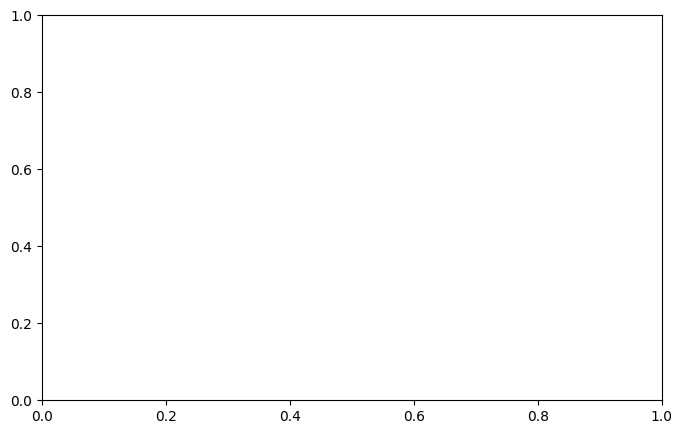

In [ ]:
# === Plot Train & Validation Loss === (Add this after training loop)

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), 100*train_relative_loss_history, marker='o', linestyle='-', label="Train Loss")
plt.plot(range(num_epochs), 100*valid_relative_loss_history, marker='s', linestyle='--', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Relative loss (%)")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

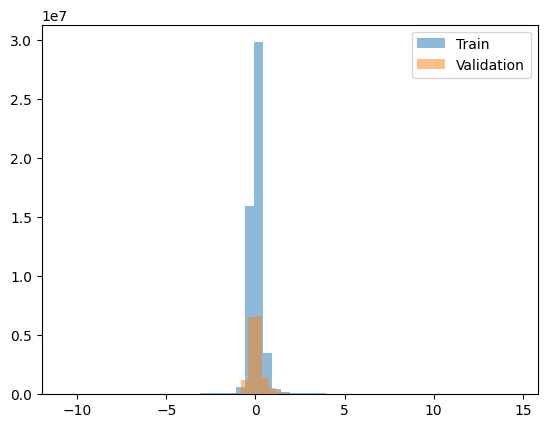

In [ ]:
plt.hist(Y_train.flatten().cpu().numpy(), bins=50, alpha=0.5, label="Train")
plt.hist(Y_val.flatten().cpu().numpy(), bins=50, alpha=0.5, label="Validation")
plt.legend()
plt.show()

In [ ]:
# === Test Model Performance ===
model.eval()  # Set model to evaluation mode
total_test_loss = 0
total_absolute_error = 0
total_relative_error = 0
epsilon = 1e-8  # To avoid division by zero

with torch.no_grad():
    for test_inputs, test_targets in test_loader:
        test_inputs, test_targets = test_inputs.to("cuda"), test_targets.to("cuda")
        test_outputs = model(test_inputs)

        # Compute MSE Loss
        test_loss = criterion(test_outputs, test_targets)
        total_test_loss += test_loss.item()

        # Compute MAE (Mean Absolute Error)
        mae = torch.abs(test_outputs - test_targets).mean().item()
        total_absolute_error += mae

        # Compute Relative Error
        relative_error = (torch.abs(test_outputs - test_targets) / (torch.abs(test_targets) + epsilon)).mean().item()
        total_relative_error += relative_error

# Compute average test loss
avg_test_loss = total_test_loss / len(test_loader)
avg_test_mae = total_absolute_error / len(test_loader)
avg_test_relative_error = total_relative_error / len(test_loader)

print(f" Test MSE Loss: {avg_test_loss:.6f}")
print(f" Test MAE (Mean Absolute Error): {avg_test_mae:.6f}")
print(f" Test Relative Error: {avg_test_relative_error:.6f}")


 Test MSE Loss: 0.000001
 Test MAE (Mean Absolute Error): 0.000446
 Test Relative Error: 0.008405


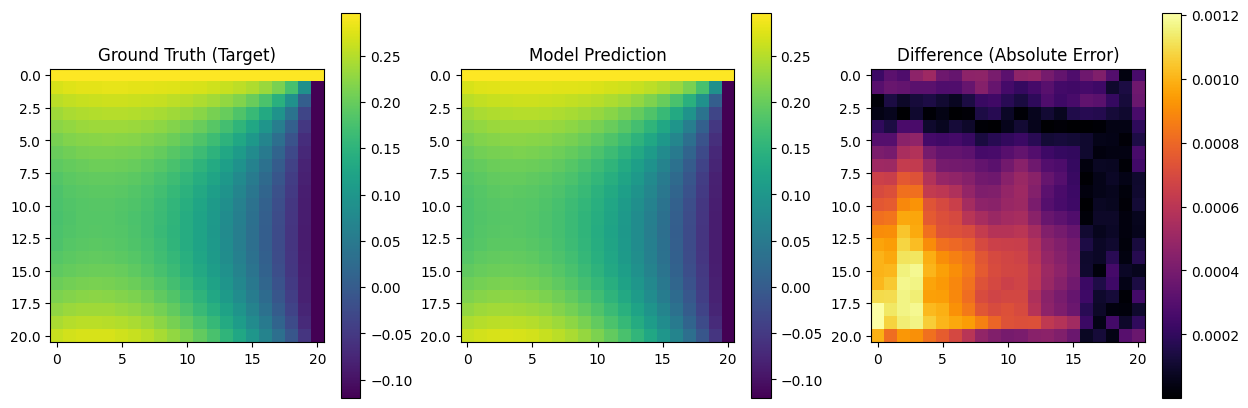

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy.random as random

# === Select a random test sample ===
# Select a random test sample
sample_idx = random.randint(0, len(test_dataset) - 1) # Change this index to visualize different test samples

# Get the test input and target
test_sample, target_sample = test_dataset[sample_idx]  # Assuming test_dataset is a TensorDataset
test_sample = test_sample.unsqueeze(0).to("cuda")  # Add batch dimension

# Get model prediction
model.eval()
with torch.no_grad():
    prediction = model(test_sample).cpu().squeeze(0)  # Remove batch dimension

# Move target to CPU for plotting
target_sample = target_sample.cpu()

# Compute the difference (absolute error)
difference = torch.abs(prediction - target_sample)

# === Plotting ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the target
im1 = axes[0].imshow(target_sample.numpy(), cmap="viridis")
axes[0].set_title("Ground Truth (Target)")
plt.colorbar(im1, ax=axes[0])

# Plot the prediction
im2 = axes[1].imshow(prediction.numpy(), cmap="viridis")
axes[1].set_title("Model Prediction")
plt.colorbar(im2, ax=axes[1])

# Plot the absolute error
im3 = axes[2].imshow(difference.numpy(), cmap="inferno")
axes[2].set_title("Difference (Absolute Error)")
plt.colorbar(im3, ax=axes[2])

plt.show()
